# Clustering Proteins with Persistent Homology Pipeline

In [1]:
# Let's start by importing necessary libraries
from transformers import EsmModel, AutoTokenizer
import gudhi as gd
import numpy as np
import torch
from scipy.spatial.distance import pdist, euclidean, squareform
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from gudhi.hera import wasserstein_distance

In [2]:

# Helper function to get the hidden states of a specific layer for a given input sequence
def get_hidden_states(tokenizer, model, layer, input_sequence):
    model.config.output_hidden_states = True
    encoded_input = tokenizer([input_sequence], return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        model_output = model(**encoded_input)
    hidden_states = model_output.hidden_states
    specific_hidden_states = hidden_states[layer][0]
    return specific_hidden_states

# Helper function to compute the Euclidean distance matrix
def compute_euclidean_distance_matrix_scipy(hidden_states):
    euclidean_distances = pdist(hidden_states.numpy(), metric=euclidean)
    euclidean_distance_matrix = squareform(euclidean_distances)
    return euclidean_distance_matrix


# Helper function to compute the persistent homology of a given distance matrix
def compute_persistent_homology(distance_matrix, max_dimension=3):
    max_edge_length = np.max(distance_matrix)
    rips_complex = gd.RipsComplex(distance_matrix=distance_matrix, max_edge_length=max_edge_length)
    st = rips_complex.create_simplex_tree(max_dimension=max_dimension)
    persistence = st.persistence()
    return st, persistence

# Helper function to compute the Wasserstein distances between all pairs of persistence diagrams
def compute_wasserstein_distances(persistence_diagrams, dimension):
    n_diagrams = len(persistence_diagrams)
    distances = np.zeros((n_diagrams, n_diagrams))
    filtered_diagrams = [[point for point in diagram if point[0] == dimension] for diagram in persistence_diagrams]
    for i in range(n_diagrams):
        for j in range(i+1, n_diagrams):
            X = np.array([p[1] for p in filtered_diagrams[i]])
            Y = np.array([p[1] for p in filtered_diagrams[j]])
            distance = wasserstein_distance(X, Y)
            distances[i][j] = distance
            distances[j][i] = distance
    return distances


In [3]:
# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
model = EsmModel.from_pretrained("facebook/esm2_t6_8M_UR50D")

Some weights of the model checkpoint at facebook/esm2_t6_8M_UR50D were not used when initializing EsmModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing EsmModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.weight', 'esm.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
# Define layer to be used
num_layers = model.config.num_hidden_layers
layer = num_layers - 1  # Index of the last layer

# Define a sample protein sequence
input_sequence = "GLSDGEWQQVLNVWGKVEADIPGHGQEVLIRLFKGHPETLEKFDKFKHLKSEDEMKASEDLKKHGATVLTALGGILKKKGHHEAELKPLAQSHATKHKIPIKYLEFISEAIIHVLHSRHPGDFGADAQGAMNKALELFRKDIAAKYKELGYQG"

# Compute the attention matrix
hidden_states_matrix = get_hidden_states(tokenizer, model, layer, input_sequence)

# Compute the Jensen-Shannon distance matrix
distance_matrix = compute_euclidean_distance_matrix_scipy(hidden_states_matrix)

# Compute the persistent homology
# max_dimension = 4 may take several minutes
# max_dimension = bigger number means the computation will take longer
st, persistence = compute_persistent_homology(distance_matrix, max_dimension=3)

<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

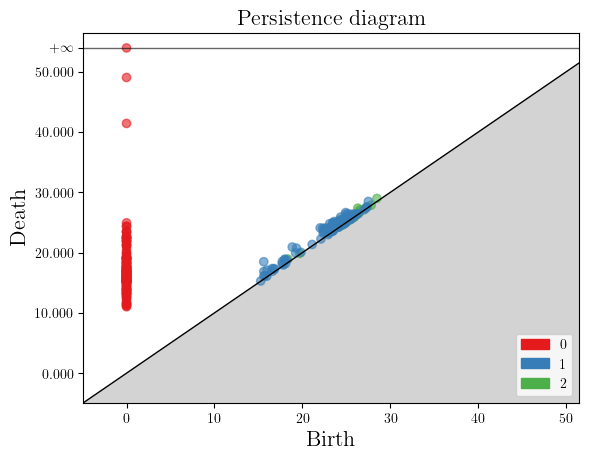

In [5]:
gd.plot_persistence_diagram(persistence)

In [8]:
sequences = [
    # Enzymes
    "MAHMTQIPLSSVKRPLQVRGIVFLGICTQKGTVYGNASWVRDQARH",
     "MKHVTQIPKSSVRRPLQFRGICFLGTCQKGTVYGKASWVHDQARHA",
     "MNHITQVPLSSAKRPLQVRGICFLGITCKNGTVYGKACWVRDQARH",

    # Transport Proteins
    "MKLITILGLLALATLVQSTGCVTVNAAHCGVTTGQTVCAGVAKCRAE",
     "MKLITILGALALATLVQSTGCVNVNAAHCVTTGQTVCAGVAKCRAET",
     "MKLITILGALALATLVQSTGCVNVNAAHCVTAGQTVCAGVAKCRAETS",

    # Structural Proteins
    "MGSSHHHHHHSSGLVPRGSHMENITVVKFNGTQTFEVHPNVSVGQAGV",
     "MGSSHHHHHHSSGLVPRGSHMENITVVKFNGTQTFEVHPNVSVGQAGVR",
     "MGSSHHHHHHSSGLVPRGSHMENITVVKFNGTQTFEVHPNVSVGQAGVRR",

    # Signaling Proteins
    "MGGHNGWQILVKGKWTTMDFLRNAVIDQKLRRARRELKLMKAFESLK",
     "MGGHNGWQILVKGKWTTMDFLRNAVIDQKLRRARRELKLMKAFESLKN",
     "MGGHNGWQILVKGKWTTMDFLRNAVIDQKLRRARRELKLMKAFESLKNN",

    # Regulatory Proteins
    "MAQSNISDAMVQLTPAGRSLMLLVQHGSQVAAGVTFQDNQRFPGGRD",
     "MAQSNISDAMVQLTPAGRSLMLLVQHGSQVAAGVTFQDNQRFPGGRDF",
     "MAQSNISDAMVQLTPAGRSLMLLVQHGSQVAAGVTFQDNQRFPGGRDFF"
]


# Initialize list to store persistent diagrams
persistent_diagrams = []

# Compute persistent homology for each sequence
for sequence in sequences:
    hidden_states_matrix = get_hidden_states(tokenizer, model, layer, sequence)
    distance_matrix = compute_euclidean_distance_matrix_scipy(hidden_states_matrix)
    _, persistence_diagram = compute_persistent_homology(distance_matrix)
    
    # Store the persistent diagram
    persistent_diagrams.append(persistence_diagram)

In [9]:
# Compute the Wasserstein distances between all pairs of persistence diagrams
wasserstein_distances = compute_wasserstein_distances(persistent_diagrams, 1)

In [10]:
# Compute the persistent homology of the Wasserstein distance matrix
st_2, persistence_2 = compute_persistent_homology(wasserstein_distances)

<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

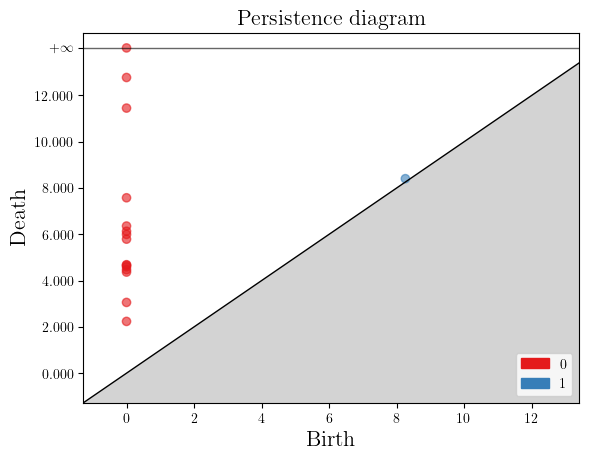

In [11]:
# Plot the persistence diagram
gd.plot_persistence_diagram(persistence_2)


In [20]:
# Perform KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=0).fit(wasserstein_distances)
labels_kmeans = kmeans.labels_
print("Silhouette Coefficient for KMeans: %0.3f" % silhouette_score(wasserstein_distances, labels_kmeans))

# Perform Agglomerative Clustering
agg_clustering = AgglomerativeClustering(n_clusters=4, affinity='precomputed', linkage='average').fit(wasserstein_distances)
labels_agg = agg_clustering.labels_
print("Silhouette Coefficient for Agglomerative Clustering: %0.3f" % silhouette_score(wasserstein_distances, labels_agg))

# Perform DBSCAN clustering
dbscan = DBSCAN(metric="precomputed", eps=7.0, min_samples=1).fit(wasserstein_distances)
labels_dbscan = dbscan.labels_
if len(set(labels_dbscan)) > 1:  # More than 1 cluster
    print("Silhouette Coefficient for DBSCAN: %0.3f" % silhouette_score(wasserstein_distances, labels_dbscan))
else:
    print("Cannot compute Silhouette Coefficient for DBSCAN as there is only one cluster.")


Silhouette Coefficient for KMeans: 0.384
Silhouette Coefficient for Agglomerative Clustering: 0.416
Silhouette Coefficient for DBSCAN: 0.416


/Users/amelieschreiber/vscode_projects/vision_persistent_homology/.conda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/amelieschreiber/vscode_projects/vision_persistent_homology/.conda/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [21]:
# Print the clusters for KMeans
print("Clusters for KMeans:")
kmeans_clusters = {i: [] for i in set(labels_kmeans)}
for sequence, label in zip(sequences, labels_kmeans):
    kmeans_clusters[label].append(sequence)
for label, cluster in kmeans_clusters.items():
    print(f"Cluster {label}: {cluster}")

# Print the clusters for Agglomerative Clustering
print("\nClusters for Agglomerative Clustering:")
agg_clusters = {i: [] for i in set(labels_agg)}
for sequence, label in zip(sequences, labels_agg):
    agg_clusters[label].append(sequence)
for label, cluster in agg_clusters.items():
    print(f"Cluster {label}: {cluster}")

# Print the clusters for DBSCAN
print("\nClusters for DBSCAN:")
dbscan_clusters = {i: [] for i in set(labels_dbscan)}
for sequence, label in zip(sequences, labels_dbscan):
    dbscan_clusters[label].append(sequence)
for label, cluster in dbscan_clusters.items():
    print(f"Cluster {label}: {cluster}")


Clusters for KMeans:
Cluster 0: ['MGGHNGWQILVKGKWTTMDFLRNAVIDQKLRRARRELKLMKAFESLK', 'MGGHNGWQILVKGKWTTMDFLRNAVIDQKLRRARRELKLMKAFESLKN', 'MGGHNGWQILVKGKWTTMDFLRNAVIDQKLRRARRELKLMKAFESLKNN', 'MAQSNISDAMVQLTPAGRSLMLLVQHGSQVAAGVTFQDNQRFPGGRD', 'MAQSNISDAMVQLTPAGRSLMLLVQHGSQVAAGVTFQDNQRFPGGRDF', 'MAQSNISDAMVQLTPAGRSLMLLVQHGSQVAAGVTFQDNQRFPGGRDFF']
Cluster 1: ['MKLITILGLLALATLVQSTGCVTVNAAHCGVTTGQTVCAGVAKCRAE', 'MKLITILGALALATLVQSTGCVNVNAAHCVTTGQTVCAGVAKCRAET', 'MKLITILGALALATLVQSTGCVNVNAAHCVTAGQTVCAGVAKCRAETS']
Cluster 2: ['MGSSHHHHHHSSGLVPRGSHMENITVVKFNGTQTFEVHPNVSVGQAGV', 'MGSSHHHHHHSSGLVPRGSHMENITVVKFNGTQTFEVHPNVSVGQAGVR', 'MGSSHHHHHHSSGLVPRGSHMENITVVKFNGTQTFEVHPNVSVGQAGVRR']
Cluster 3: ['MAHMTQIPLSSVKRPLQVRGIVFLGICTQKGTVYGNASWVRDQARH', 'MKHVTQIPKSSVRRPLQFRGICFLGTCQKGTVYGKASWVHDQARHA', 'MNHITQVPLSSAKRPLQVRGICFLGITCKNGTVYGKACWVRDQARH']

Clusters for Agglomerative Clustering:
Cluster 0: ['MAHMTQIPLSSVKRPLQVRGIVFLGICTQKGTVYGNASWVRDQARH', 'MKHVTQIPKSSVRRPLQFRGICFLGTCQKGTVYGKASWVHDQARHA', 'MNH

In [22]:
from sklearn.metrics import adjusted_rand_score

# Calculate ARIs
ari_kmeans_agg = adjusted_rand_score(labels_kmeans, labels_agg)
ari_kmeans_dbscan = adjusted_rand_score(labels_kmeans, labels_dbscan)
ari_agg_dbscan = adjusted_rand_score(labels_agg, labels_dbscan)

# Print ARIs
print(f"Adjusted Rand Index for KMeans and Agglomerative Clustering: {ari_kmeans_agg}")
print(f"Adjusted Rand Index for KMeans and DBSCAN: {ari_kmeans_dbscan}")
print(f"Adjusted Rand Index for Agglomerative Clustering and DBSCAN: {ari_agg_dbscan}")


Adjusted Rand Index for KMeans and Agglomerative Clustering: 0.5625
Adjusted Rand Index for KMeans and DBSCAN: 0.5625
Adjusted Rand Index for Agglomerative Clustering and DBSCAN: 1.0
